# Vector Autoregression (VAR) Model Notebook (Corrected)

This notebook reads two stock series from Yahoo Finance (using `Ticker.history` to avoid column issues), conducts stationarity tests (ADF), computes lag correlations, and fits a VAR model with impulse response functions.

**Sections:**
1. Install Requirements  
2. Imports  
3. Data Download (Corrected)  
4. Stationarity Tests  
5. Lag Correlation Plots  
6. VAR Model Fitting  
7. Impulse Response Functions

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import yfinance as yf

In [6]:
# Download close prices via Ticker.history to avoid 'Adj Close' KeyError
tickers = ['AAPL', 'MSFT']
data = pd.DataFrame()

for t in tickers:
    hist = yf.Ticker(t).history(start='2020-01-01', end='2025-01-01')
    data[t] = hist['Close']

data = data.dropna()
data.head()

,AAPL,MSFT
Date,,
2020-01-02 00:00:00-05:00,72.620834,153.042313
2020-01-03 00:00:00-05:00,71.914810,151.136673
2020-01-06 00:00:00-05:00,72.487862,151.527298
2020-01-07 00:00:00-05:00,72.146935,150.145737
2020-01-08 00:00:00-05:00,73.307495,152.537292


In [7]:
# Define ADF test function
def adf_test(series, title=''):
    print(f'--- Augmented Dickey-Fuller Test: {title} ---')
    result = adfuller(series)
    labels = ['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    output = pd.Series(result[:4], index=labels)
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value
    print(output.to_string(), '\n')

# Test each original series
for name in data.columns:
    adf_test(data[name], title=name)

--- Augmented Dickey-Fuller Test: AAPL ---
Test Statistic                   -0.708406
p-value                           0.844560
#Lags Used                        0.000000
Number of Observations Used    1257.000000
Critical Value (1%)              -3.435563
Critical Value (5%)              -2.863842
Critical Value (10%)             -2.567996 

--- Augmented Dickey-Fuller Test: MSFT ---
Test Statistic                   -1.001772
p-value                           0.752618
#Lags Used                        9.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004 



In [8]:
# Compute log returns and drop missing
returns = np.log(data).diff().dropna()

# ADF on returns
for name in returns.columns:
    adf_test(returns[name], title=f'{name} Log Returns')

--- Augmented Dickey-Fuller Test: AAPL Log Returns ---
Test Statistic                -1.128437e+01
p-value                        1.430078e-20
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00 

--- Augmented Dickey-Fuller Test: MSFT Log Returns ---
Test Statistic                -1.125107e+01
p-value                        1.711496e-20
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00 



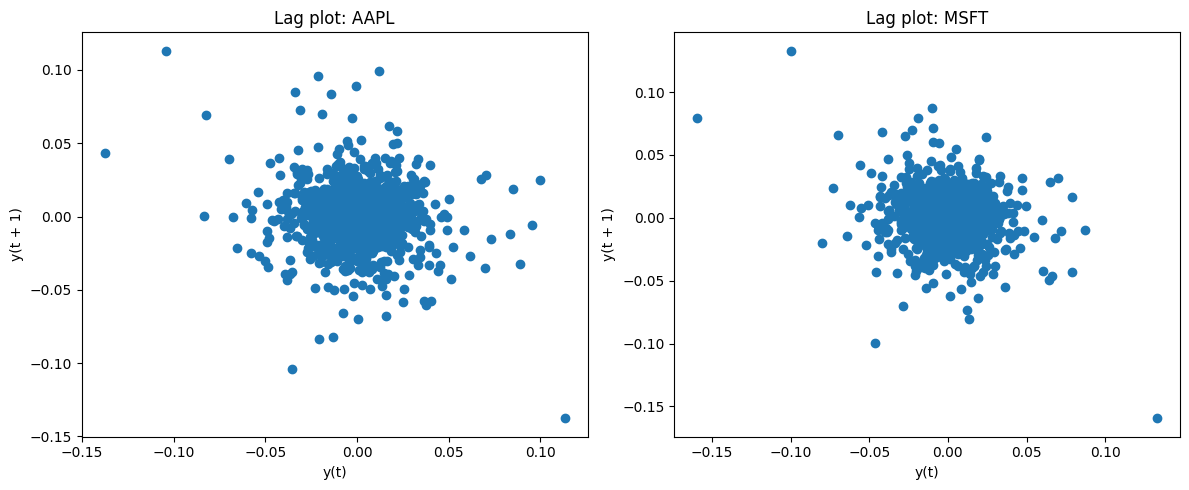

In [9]:
# Plot lag plots for each series
from pandas.plotting import lag_plot

plt.figure(figsize=(12,5))
for i, col in enumerate(returns.columns):
    plt.subplot(1,2,i+1)
    lag_plot(returns[col])
    plt.title(f'Lag plot: {col}')
plt.tight_layout()
plt.show()

In [10]:
# Fit a VAR model
model = VAR(returns)
lag_order = model.select_order(maxlags=15)
print('Lag Order Selection Criteria:')
print(lag_order.summary())

# Select lag by AIC
p = lag_order.selected_orders['aic']
print(f'Fitting VAR with lag order = {p}')

results = model.fit(p)
print(results.summary())

Lag Order Selection Criteria:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -16.54      -16.53   6.539e-08      -16.54
1       -16.58     -16.55*   6.326e-08     -16.57*
2       -16.57      -16.53   6.365e-08      -16.55
3       -16.57      -16.52   6.343e-08      -16.55
4       -16.57      -16.50   6.362e-08      -16.54
5       -16.57      -16.48   6.368e-08      -16.54
6       -16.57      -16.47   6.348e-08      -16.53
7       -16.59      -16.46   6.260e-08      -16.54
8       -16.59      -16.45   6.241e-08      -16.54
9       -16.60      -16.45   6.163e-08      -16.54
10     -16.61*      -16.44  6.123e-08*      -16.54
11      -16.61      -16.42   6.139e-08      -16.53
12      -16.60      -16.39   6.176e-08      -16.52
13      -16.60      -16.38   6.189e-08      -16.51
14      -16.59      -16.35   6.220e-08      -16.50
15      -16.59      -16.34   6.211e-08      -16.50
-

/Users/hadi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


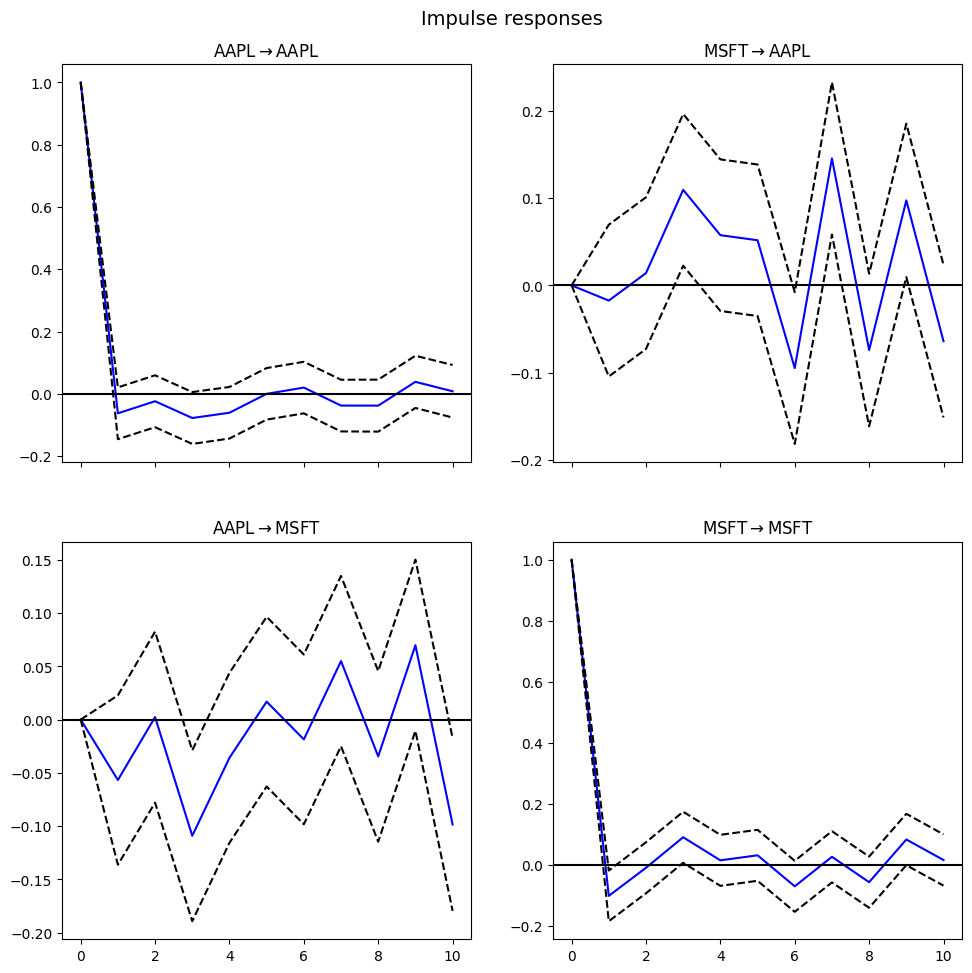

In [11]:
# Impulse Response Function
irf = results.irf(10)
irf.plot(orth=False)
plt.show()